In [127]:
import os
from pathlib import Path
import laspy
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import pandas as pd
import re
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio
import seaborn as sns
from datetime import datetime, timedelta
from numpy.polynomial.polynomial import Polynomial
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
import scipy.io as sio
from scipy.stats import mode
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from grid_utils import *

In [137]:
cropped_grid = np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/cropped_clusters.npz")['data']
cropped_clusters = np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/cropped_clusters.npz")['data']

grid_files = np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/cluster_files.npz")['data']
cluster_files = np.load("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/cluster_files.npz")['data']

volume_df = pd.read_csv("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/volume_df.csv")

In [138]:
volume_df

,start_date,end_date,midpoint_date,volume,centroid_indices,clusterID
0,2021-05-04,2021-07-14,2021-06-08 12:00:00,1073.083459,"(6229, 125)",146.0
1,2018-09-26,2018-10-05,2018-09-30 12:00:00,778.155005,"(15579, 178)",30.0
2,2021-08-09,2021-09-13,2021-08-26 12:00:00,497.128004,"(6138, 77)",17.0
3,2019-02-15,2019-02-19,2019-02-17 00:00:00,249.441512,"(14677, 174)",181.0
4,2021-02-08,2021-03-09,2021-02-22 12:00:00,226.874215,"(6240, 147)",708.0
...,...,...,...,...,...,...
26921,2019-11-26,2019-12-02,2019-11-29 00:00:00,0.006140,"(44, 119)",499.0
26922,2018-12-18,2018-12-26,2018-12-22 00:00:00,0.005579,"(11657, 21)",450.0
26923,2023-09-18,2023-09-29,2023-09-23 12:00:00,0.003523,"(13965, 23)",157.0
26924,2018-12-18,2018-12-26,2018-12-22 00:00:00,0.003472,"(15057, 44)",243.0


In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_mag_freq_per_year(volume_df):
    """
    Plots magnitude-frequency curves for each year on the same plot, and the total magnitude-frequency curve
    in black.
    
    Parameters:
    volume_df (pd.DataFrame): A DataFrame containing cluster volume information.
                              Must contain 'volume' and 'midpoint_date' columns.
    """
    # Ensure 'midpoint_date' column is in datetime format
    volume_df['date'] = pd.to_datetime(volume_df['midpoint_date'])

    # Extract the year from the dates
    volume_df['year'] = volume_df['date'].dt.year

    # Set up the plot
    plt.figure(figsize=(8, 6))

    # Collect handles and labels for the legend
    handles, labels = [], []

    # Calculate total magnitude-frequency curve
    total_sorted_volumes = volume_df['volume'].sort_values(ascending=False)
    total_ranks = np.arange(1, len(total_sorted_volumes) + 1)

    # Downsample for readability
    total_log_indices = np.unique(np.logspace(0, np.log10(len(total_sorted_volumes) - 1), num=50).astype(int))
    total_downsampled_volumes = total_sorted_volumes.iloc[total_log_indices]
    total_downsampled_ranks = total_ranks[total_log_indices]

    # Plot the total magnitude-frequency curve (larger markers and thicker line in black)
    total_line, = plt.loglog(total_downsampled_volumes, total_downsampled_ranks, marker='D', linestyle='-', 
                             color='black', markersize=5, linewidth=2, label='All Years')
    handles.append(total_line)  # Add the total curve to the legend
    labels.append('Total')

    # Plot yearly magnitude-frequency curves
    for year, group in volume_df.groupby('year'):
        # Sort volumes in descending order
        sorted_volumes = group['volume'].sort_values(ascending=False)
        
        # Compute ranks (cumulative frequency)
        ranks = np.arange(1, len(sorted_volumes) + 1)

        # Downsample for readability using logarithmic downsampling
        log_indices = np.unique(np.logspace(0, np.log10(len(sorted_volumes) - 1), num=50).astype(int))

        # Select downsampled volumes and ranks
        downsampled_volumes = sorted_volumes.iloc[log_indices]
        downsampled_ranks = ranks[log_indices]

        # Plot the log-log magnitude-frequency curve for the current year (smaller diamond markers)
        line, = plt.loglog(downsampled_volumes, downsampled_ranks, marker='D', linestyle='-', markersize=2, label=str(year))
        handles.append(line)  # Collect the handle for the legend
        labels.append(str(year))



    # Formatting the plot
    plt.xlabel('Volume (m³)', fontsize=14, fontweight='bold')
    plt.ylabel('Frequency', fontsize=14, fontweight='bold')
    plt.title('Cliff Failure Magnitude-Frequency', fontsize=16, fontweight='bold')
    plt.grid(True, which="major", linestyle="--", alpha=0.5)

    # Combined legend in the top right corner
    plt.legend(handles, labels, title="Year", fontsize=9, loc='upper right')

    # Set limits for better visibility
    plt.xlim(1e-1, 1e3)

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming volume_df contains 'volume' and 'midpoint_date' columns
# plot_mag_freq_per_year(volume_df)


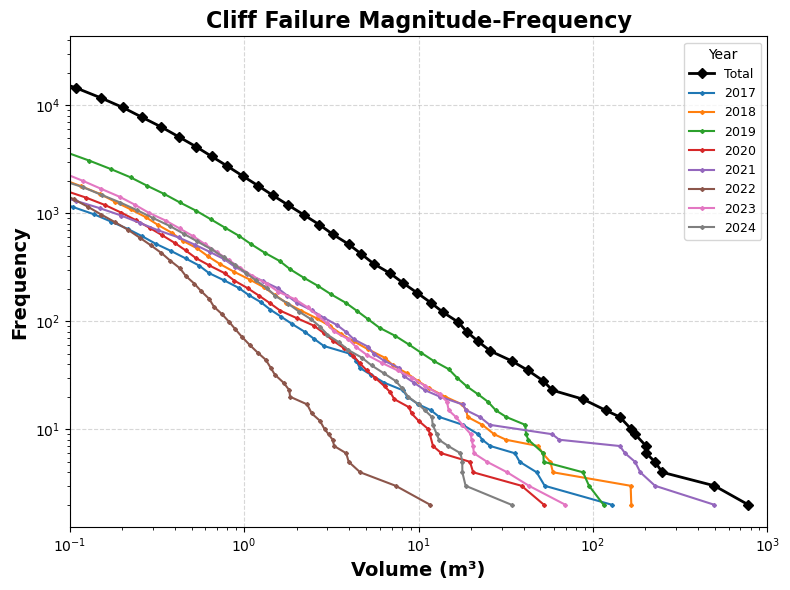

In [126]:
plot_mag_freq_per_year(volume_df)

In [110]:
import pandas as pd
import numpy as np

def get_stats(volume_df, minVolume=0):

    volumes = volume_df.copy()
    # Ensure centroid_indices is evaluated correctly if stored as strings
    # volumes = volume_df.copy()
    volumes['centroid_indices'] = volumes['centroid_indices'].apply(eval)
    
    # Calculate centroid elevation as the second element of centroid_indices divided by 10
    volumes['centroid_elevation'] = volumes['centroid_indices'].apply(lambda x: x[1] / 10)
    
    # Extract year from 'midpoint_date'
    volumes['midpoint_date'] = pd.to_datetime(volumes['midpoint_date'])
    volumes['year'] = volumes['midpoint_date'].dt.year
    
    # Filter rows based on minVolume
    filtered_volumes = volumes[volumes['volume'] >= minVolume]
    
    # Aggregating statistics by year
    aggregated_table = filtered_volumes.groupby('year').agg(
        mean_volume=('volume', 'mean'),
        std_volume=('volume', 'std'),
        min_volume=('volume', 'min'),
        max_volume=('volume', 'max'),
        mean_centroid_elev=('centroid_elevation', 'mean'),
        std_centroid_elev=('centroid_elevation', 'std'),
        min_centroid_elev=('centroid_elevation', 'min'),
        max_centroid_elev=('centroid_elevation', 'max'),
        count=('volume', 'count')
    ).reset_index()
    
    # Renaming columns to match the required format
    aggregated_table.rename(columns={
        'mean_volume': 'Volume Mean (m³)',
        'std_volume': 'Volume Std. (m³)',
        'min_volume': 'Volume Min (m³)',
        'max_volume': 'Volume Max (m³)',
        'mean_centroid_elev': 'Centroid Elev. Mean (m)',
        'std_centroid_elev': 'Centroid Elev. Std. (m)',
        'min_centroid_elev': 'Centroid Elev. Min (m)',
        'max_centroid_elev': 'Centroid Elev. Max (m)',
        'count': 'Count'
    }, inplace=True)
    
    # Round all values to 2 decimal places
    rounded_table = aggregated_table.round(3)
    
    return rounded_table


In [117]:
stats_df = get_stats(volume_df, minVolume=.1)
stats_df

,year,Volume Mean (m³),Volume Std. (m³),Volume Min (m³),Volume Max (m³),Centroid Elev. Mean (m),Centroid Elev. Std. (m),Centroid Elev. Min (m),Centroid Elev. Max (m),Count
0,2017,1.207,7.646,0.1,201.741,7.311,5.246,1.9,22.4,1172
1,2018,1.424,18.646,0.1,778.155,7.368,5.032,1.9,23.1,1949
2,2019,1.077,5.865,0.1,249.442,7.705,4.855,1.9,23.7,3573
3,2020,0.865,5.539,0.1,201.630,8.520,5.250,1.9,24.0,1558
4,2021,2.891,33.967,0.1,1073.083,8.286,5.193,2.2,23.0,1356
5,2022,0.383,1.240,0.1,42.481,9.411,5.051,2.3,22.8,1413
6,2023,0.842,3.596,0.1,118.135,6.859,4.190,2.1,22.8,2227
7,2024,0.789,2.948,0.1,105.224,6.585,3.924,1.9,23.3,1909


In [116]:
stats_df.to_csv("/Users/cjmack/Documents/Papers/Cliffs/Code/local_grids/stats_df.csv")

Epoch 1/100


/opt/anaconda3/envs/m3c2/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8324.3477 - mae: 39.9648 - val_loss: 21891.3262 - val_mae: 49.5759
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 13327.3672 - mae: 47.4110 - val_loss: 21865.9883 - val_mae: 49.3214
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11467.0449 - mae: 44.1058 - val_loss: 21839.3262 - val_mae: 49.0588
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 21256.1719 - mae: 50.4062 - val_loss: 21811.7441 - val_mae: 48.7845
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 24370.2246 - mae: 56.4794 - val_loss: 21782.2637 - val_mae: 48.4792
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13304.5264 - mae: 47.0070 - val_loss: 21749.0449 - val_mae: 48.1459
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11216.4658 - mae: 46.0225 - val_loss: 21711.2383 - val_mae: 47.7754
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11665.4785 - mae: 43.6821 - val_loss: 21669.0566 - val_mae: 47.3622
Epoch 9/100


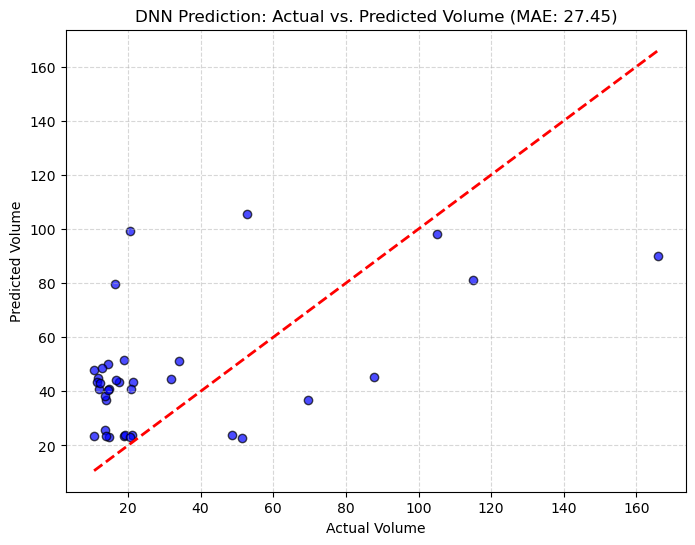

In [139]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

# Load the data
# volume_df = pd.read_csv("volume_df.csv")

# Extract year and convert date to a numerical feature
volume_df['year'] = pd.to_datetime(volume_df['midpoint_date']).dt.year
volume_df['days_from_start'] = (pd.to_datetime(volume_df['midpoint_date']) - pd.to_datetime("2000-01-01")).dt.days

# Calculate centroid elevation directly from tuples
volume_df['centroid_indices'] = volume_df['centroid_indices'].apply(eval)
    
    # Calculate centroid elevation as the second element of centroid_indices divided by 10
volume_df['centroid_elevation'] = volume_df['centroid_indices'].apply(lambda x: x[1] / 10)

# Filter volumes greater than 10 m³ for training
filtered_df = volume_df[volume_df['volume'] > 10.0]

# Prepare features (centroid elevation and date) and target (volume)
X = filtered_df[['centroid_elevation', 'days_from_start']].values
y = filtered_df['volume'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the DNN model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)

# Predict the volume
y_pred = model.predict(X_test).flatten()

# Plot actual vs predicted volume
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', edgecolor='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2)
plt.xlabel('Actual Volume')
plt.ylabel('Predicted Volume')
plt.title(f'DNN Prediction: Actual vs. Predicted Volume (MAE: {mae:.2f})')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
